In [2]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import json
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Generic methods to convert json format to DataFrame

In [65]:
def compute_metrics(data : dict):
    oc_list = list()
    available_list = list()
    prev_available_list = list()
    deltabooked_list = list()
    correction_list = list()
    percentile_list = list()
    prev_percentile_list = list()
    config_list = list()
    booked_list = list()
    prev_booked = 0
    prev_available = 0
    prev_percentile = 0
    for index in range(len(data["epoch"])):
        available = data["model"]["free_cpu"][index]
        config = data['node']["cpu_config"][index]
        ratio = (data['node']["booked_cpu"][index] + data["model"]["free_cpu"][index])/data['node']["cpu_config"][index]
        percentile = data['node']['cpu_percentile'][index]['99'] 
        booked_list.append(data['node']["booked_cpu"][index])
        delta_booked = data['node']["booked_cpu"][index] - prev_booked
        oc_list.append(ratio)
        available_list.append(available)
        prev_available_list.append(prev_available)
        deltabooked_list.append(delta_booked)
        if delta_booked>=0:
            correction_list.append(delta_booked)
        else:
            correction_list.append(percentile - prev_percentile)
        percentile_list.append(percentile)
        prev_percentile_list.append(prev_percentile)
        config_list.append(config)
        prev_available = available
        prev_percentile = percentile
        prev_booked = data['node']["booked_cpu"][index]
    return oc_list, available_list, prev_available_list, deltabooked_list, correction_list, percentile_list, prev_percentile_list, config_list, booked_list

def add_line(dict_to_use : dict, curr_strategy, curr_iteration, oc_ratio, available, prev_available, delta_booked, correction, percentile, prev_percentile, config, booked_cpu):
    dict_to_use["strategy"].append(curr_strategy)
    dict_to_use["iteration"].append(curr_iteration)
    dict_to_use["ratio"].append(oc_ratio)
    dict_to_use["available"].append(available)
    dict_to_use["prev_available"].append(prev_available)
    dict_to_use["delta_booked"].append(delta_booked)
    dict_to_use["correction"].append(correction)
    dict_to_use["percentile"].append(percentile)
    dict_to_use["prev_percentile"].append(prev_percentile)
    dict_to_use["config"].append(config)
    dict_to_use["booked"].append(booked_cpu)

def convert_res_to_cumul(input_df : pd.DataFrame):
    pd.options.mode.chained_assignment = None 
    
    cumul_res_dic= dict()
    cumul_res_dic['strategy'] = list()
    cumul_res_dic['iteration'] = list()
    cumul_res_dic['violation'] = list()
    cumul_res_dic['violation_cumulated'] = list()
    cumul_res_dic['violation_cumulated%'] = list()
    cumul_res_dic['misprediction'] = list()
    cumul_res_dic['misprediction_cumulated'] = list()
    cumul_res_dic['misprediction_cumulated%'] = list()
    cumul_res_dic['decreases'] = list()
    cumul_res_dic['decreases_cumulated'] = list()
    cumul_res_dic['decreases_cumulated%'] = list()

    for strategy in list(input_df['strategy'].unique()):

        x = input_df.loc[input_df['strategy'] ==  strategy]
        x['violation'] = x['current_available_misprediction'].apply(lambda x : np.abs(x) if x < 0 else 0)
        x['misprediction'] = x['current_available_misprediction'].apply(lambda x : np.abs(x))
        x['decreases'] = x['delta_available'].apply(lambda x : np.abs(x) if x < 0 else 0)

        iteration_list = list()
        violation_list = list()
        violation_cumulated_list = list()
        violation_cumulated_val = 0
        misprediction_list = list()
        misprediction_cumulated_list = list()
        misprediction_cumulated_val = 0
        decreases_list = list()
        decreases_cumulated_list = list()
        decreases_cumulated_val = 0
        for index, row in x.iterrows():
            iteration_list.append(row['iteration'])
            violation_list.append(row['violation'])
            violation_cumulated_val += row['violation']
            violation_cumulated_list.append(violation_cumulated_val)
            misprediction_list.append(row['misprediction'])
            misprediction_cumulated_val += row['misprediction']
            misprediction_cumulated_list.append(misprediction_cumulated_val)
            decreases_list.append(row['decreases'])
            decreases_cumulated_val += row['decreases']
            decreases_cumulated_list.append(decreases_cumulated_val)

        cumul_res_dic['iteration'].extend(iteration_list)
        cumul_res_dic['strategy'].extend([strategy for val in iteration_list])
        cumul_res_dic['violation'].extend(violation_list)
        cumul_res_dic['violation_cumulated'].extend(violation_cumulated_list)
        cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
        cumul_res_dic['misprediction'].extend(misprediction_list)
        cumul_res_dic['misprediction_cumulated'].extend(misprediction_cumulated_list)
        cumul_res_dic['misprediction_cumulated%'].extend([(x - np.min(misprediction_cumulated_list))/(np.max(misprediction_cumulated_list)-np.min(misprediction_cumulated_list)) for x in misprediction_cumulated_list])
        cumul_res_dic['decreases'].extend(decreases_list)
        cumul_res_dic['decreases_cumulated'].extend(decreases_cumulated_list)
        cumul_res_dic['decreases_cumulated%'].extend([(x - np.min(decreases_cumulated_list))/(np.max(decreases_cumulated_list)-np.min(decreases_cumulated_list)) for x in decreases_cumulated_list])
    
    return pd.DataFrame(cumul_res_dic)

def compute_eval_metrics(dataframe : pd.DataFrame, config : int):
    from collections import defaultdict
    res_dic = defaultdict(lambda : list())
    
    for strategy in list(dataframe['strategy'].unique()):

        res_dic['strategy'].append(strategy)

        x = dataframe.loc[dataframe['strategy'] ==  strategy]
        res_dic['misprediction'].append(x['misprediction_cumulated'].max())
        res_dic['violation'].append(x['violation_cumulated'].max())
        res_dic['decreases'].append(x['decreases_cumulated'].max())

    res_df = pd.DataFrame(res_dic)
    res_df['misprediction'] = res_df['misprediction'].apply(lambda x : round(x/config,1))
    res_df['violation'] = res_df['violation'].apply(lambda x : round(x/config,1))
    res_df['decreases'] = res_df['decreases'].apply(lambda x : round(x/config,1))
    
    return res_df

def load_folder(folder : str):
    input_strat = dict()
    strategies = ['borg', 'doa', 'scroogevm', 'maxpeak', 'nsigma', 'percentile', 'rclike']
    for strategy in strategies:
        input_strat[strategy] = folder + "/dump-" + strategy + ".json"
    
    compare_strat_dict = dict()
    compare_strat_dict["iteration"] = list()
    compare_strat_dict["strategy"] = list()
    compare_strat_dict["ratio"] = list()
    compare_strat_dict["available"] = list()
    compare_strat_dict["prev_available"] = list()
    compare_strat_dict["percentile"] = list()
    compare_strat_dict["booked"] = list()
    compare_strat_dict["delta_booked"] = list()
    compare_strat_dict["correction"] = list()
    compare_strat_dict["prev_percentile"] = list()
    compare_strat_dict["config"] = list()
    
    for strat, file in input_strat.items():
        print("Loading", strat, file)
        with open(file, 'r') as f:
            targeted_data = json.load(f)
        oc_list, available_list, prev_available_list, deltabooked_list, correction_list, percentile_list, prev_percentile_list, config_list, booked_list = compute_metrics(targeted_data)
        for iteration_curr in range(len(oc_list)):
            add_line(compare_strat_dict, strat, iteration_curr, oc_list[iteration_curr], available_list[iteration_curr], prev_available_list[iteration_curr], deltabooked_list[iteration_curr], correction_list[iteration_curr], percentile_list[iteration_curr], prev_percentile_list[iteration_curr], config_list[iteration_curr], booked_list[iteration_curr])
    print("Done")
    
    return compare_strat_dict

# Load the "decreasing workload" trace

In [66]:
folder = "/usr/local/src/scroogevm/dump-decrease"

decreasing_df = pd.DataFrame(load_folder(folder))

Loading borg /usr/local/src/scroogevm/dump-decrease/dump-borg.json
Loading doa /usr/local/src/scroogevm/dump-decrease/dump-doa.json
Loading scroogevm /usr/local/src/scroogevm/dump-decrease/dump-scroogevm.json
Loading maxpeak /usr/local/src/scroogevm/dump-decrease/dump-maxpeak.json
Loading nsigma /usr/local/src/scroogevm/dump-decrease/dump-nsigma.json
Loading percentile /usr/local/src/scroogevm/dump-decrease/dump-percentile.json
Loading rclike /usr/local/src/scroogevm/dump-decrease/dump-rclike.json
Done


In [67]:
decreasing_df = decreasing_df.loc[decreasing_df["iteration"] < 30]
decreasing_df = decreasing_df.loc[decreasing_df["iteration"] > 0]

decreasing_df["prev_available_corrected"] = decreasing_df["prev_available"] - decreasing_df["correction"]
decreasing_df["available_groundthruth"] = decreasing_df["config"] - decreasing_df["percentile"]
decreasing_df["delta_available"] = decreasing_df["available"] - decreasing_df["prev_available_corrected"]

decreasing_df["current_available_misprediction"] = decreasing_df["available_groundthruth"] - decreasing_df["prev_available_corrected"]
decreasing_df["current_available_misprediction%"] = decreasing_df["current_available_misprediction"] / decreasing_df["config"]
decreasing_df["oversubscription"] = (decreasing_df["booked"] + decreasing_df["available"])/decreasing_df["config"]

strategies = decreasing_df['strategy'].unique()

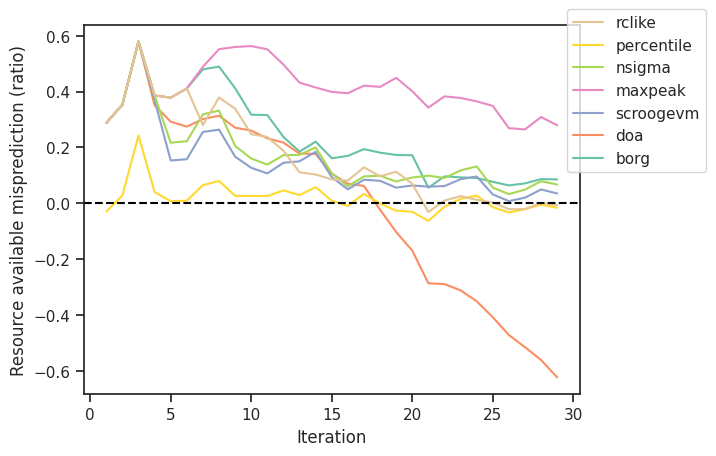

In [68]:
#hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)

sns.lineplot(data=decreasing_df, x="iteration", y="current_available_misprediction%", hue="strategy") #, palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Resource available misprediction (ratio)')

/tmp/ipykernel_324858/3567779449.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
/tmp/ipykernel_324858/3567779449.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
/tmp/ipykernel_324858/3567779449.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
/tmp/ipykernel_324858/3567779449.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumu

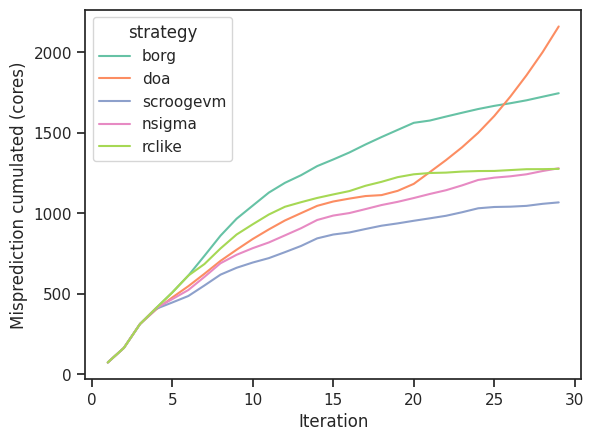

In [70]:
decreasing_cumul_res_df = convert_res_to_cumul(input_df=decreasing_df)

without_doa = decreasing_cumul_res_df.loc[decreasing_cumul_res_df['strategy'] != 'percentile']
without_doa = without_doa.loc[without_doa['strategy'] != 'maxpeak']
# decreases_cumulated violation_cumulated misprediction_cumulated

#sns.set_color_codes(palette='Set2')
sns.set_theme(style="ticks")
sns.set_palette(palette='Set2')
x = sns.lineplot(data=without_doa, x="iteration", y="misprediction_cumulated", hue="strategy")
x.set_xlabel('Iteration')
x.set_ylabel('Misprediction cumulated (cores)')
plt.gcf().savefig('figures/misprediction-decreasing.pdf', bbox_inches='tight')

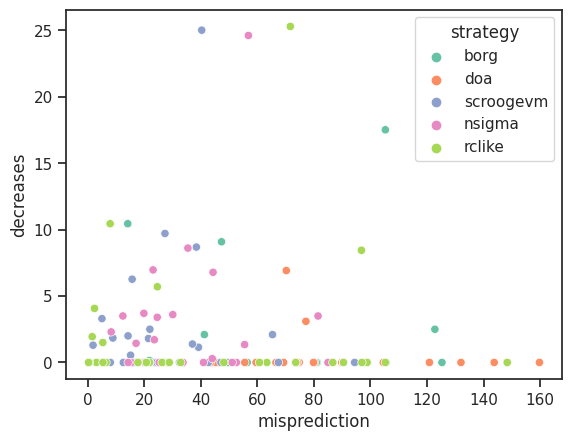

In [71]:
x = sns.scatterplot(without_doa, x='misprediction', y='decreases', hue='strategy')

In [72]:
res_df = compute_eval_metrics(decreasing_cumul_res_df, config=256)

res_df_x = res_df.loc[res_df['strategy'] != 'doa']
res_df_x.head(n=10)

,strategy,misprediction,violation,decreases
0,borg,6.8,0.0,0.2
2,scroogevm,4.2,0.0,0.3
3,maxpeak,11.9,0.0,0.3
4,nsigma,5.0,0.0,0.3
5,percentile,1.0,0.3,0.2
6,rclike,5.0,0.1,0.2


In [85]:
for strategy in decreasing_df['strategy'].unique():
    x = decreasing_df.loc[decreasing_df['strategy'] == strategy]
    print(strategy, round(x['oversubscription'].max(),2))
    #print(strategy, round(x['oversubscription'].min(),2), round(x['oversubscription'].mean(),2), round(x['oversubscription'].max(),2))

borg 1.44
doa 1.79
scroogevm 1.67
maxpeak 1.44
nsigma 1.6
percentile 1.81
rclike 1.44


# Load the "increasing workload" trace

In [74]:
folder = "/usr/local/src/scroogevm/dump-increase"

increasing_df = pd.DataFrame(load_folder(folder))

Loading borg /usr/local/src/scroogevm/dump-increase/dump-borg.json
Loading doa /usr/local/src/scroogevm/dump-increase/dump-doa.json
Loading scroogevm /usr/local/src/scroogevm/dump-increase/dump-scroogevm.json
Loading maxpeak /usr/local/src/scroogevm/dump-increase/dump-maxpeak.json
Loading nsigma /usr/local/src/scroogevm/dump-increase/dump-nsigma.json
Loading percentile /usr/local/src/scroogevm/dump-increase/dump-percentile.json
Loading rclike /usr/local/src/scroogevm/dump-increase/dump-rclike.json
Done


In [75]:
increasing_df = increasing_df.loc[increasing_df["iteration"] < 30]
increasing_df = increasing_df.loc[increasing_df["iteration"] > 0]

increasing_df["prev_available_corrected"] = increasing_df["prev_available"] - increasing_df["correction"]
increasing_df["delta_available"] = increasing_df["available"] - increasing_df["prev_available_corrected"]
increasing_df["current_available"] = increasing_df["config"] - increasing_df["percentile"]
increasing_df["oversubscription"] = (increasing_df["booked"] + increasing_df["available"])/increasing_df["config"]

increasing_df["current_available_misprediction"] = increasing_df["current_available"] - increasing_df["prev_available_corrected"]
increasing_df["current_available_misprediction%"] = increasing_df["current_available_misprediction"] / increasing_df["config"]

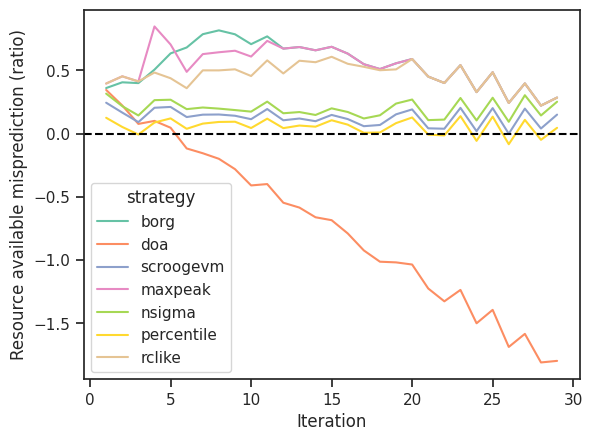

In [76]:
#hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)

sns.lineplot(data=increasing_df, x="iteration", y="current_available_misprediction%", hue="strategy") # , palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.ylabel('Resource available misprediction (ratio)')

Strategy borg negative variation count: 0 average: nan max nan
Strategy doa negative variation count: 1 average: -87.0 max -87.0
Strategy scroogevm negative variation count: 1 average: -1.0 max -1.0
Strategy maxpeak negative variation count: 2 average: -44.900000000000006 max -83.2
Strategy nsigma negative variation count: 2 average: -1.600000000000005 max -2.9000000000000057
Strategy percentile negative variation count: 0 average: nan max nan
Strategy rclike negative variation count: 1 average: -6.799999999999997 max -6.799999999999997


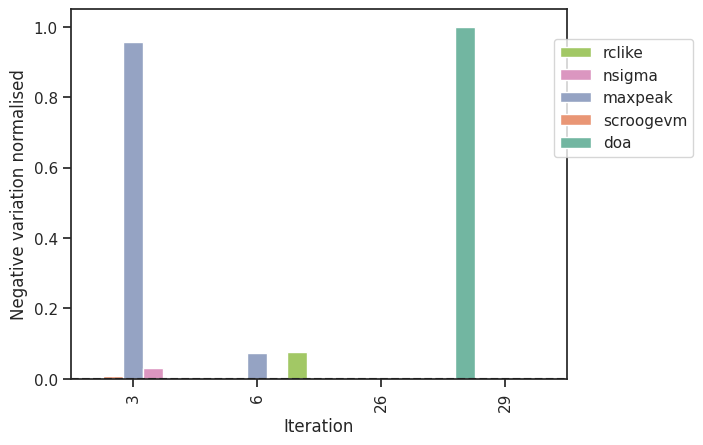

In [77]:
pd.options.mode.chained_assignment = None 
filter_df = increasing_df.loc[increasing_df['delta_available'] < 0]
min_val = filter_df['delta_available'].min()
max_val = filter_df['delta_available'].max()
filter_df['delta_available_norm'] = filter_df['delta_available'].apply(lambda x : (x - max_val) / (min_val - max_val))

sns.barplot(data=filter_df, x="iteration", y="delta_available_norm", hue="strategy")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Negative variation normalised')
x = plt.xticks(rotation=90)

strategies = increasing_df['strategy'].unique()
for strategy in strategies:
    filter_strategy_df = filter_df.loc[filter_df['strategy'] ==  strategy]
    st_mean = filter_strategy_df['delta_available'].mean()
    st_max = filter_strategy_df['delta_available'].min()
    print("Strategy", strategy, "negative variation count:", len(filter_strategy_df), "average:", st_mean, "max", st_max)

/tmp/ipykernel_324858/3567779449.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
/tmp/ipykernel_324858/3567779449.py:105: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['decreases_cumulated%'].extend([(x - np.min(decreases_cumulated_list))/(np.max(decreases_cumulated_list)-np.min(decreases_cumulated_list)) for x in decreases_cumulated_list])
/tmp/ipykernel_324858/3567779449.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
/tmp/ipykernel_324858/3567779449.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cum

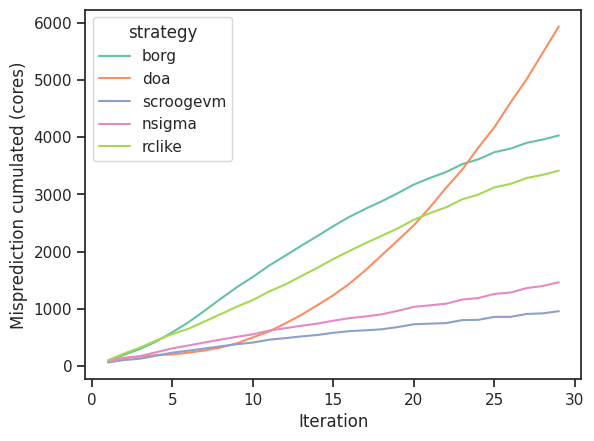

In [78]:
increasing_cumul_res_df = convert_res_to_cumul(input_df=increasing_df)

without_doa = increasing_cumul_res_df.loc[increasing_cumul_res_df['strategy'] != 'percentile']
without_doa = without_doa.loc[without_doa['strategy'] != 'maxpeak']
# decreases_cumulated violation_cumulated misprediction_cumulated

#sns.set_color_codes(palette='Set2')
sns.set_theme(style="ticks")
sns.set_palette(palette='Set2')
x = sns.lineplot(data=without_doa, x="iteration", y="misprediction_cumulated", hue="strategy")
x.set_xlabel('Iteration')
x.set_ylabel('Misprediction cumulated (cores)')
plt.gcf().savefig('figures/misprediction-increasing.pdf', bbox_inches='tight')

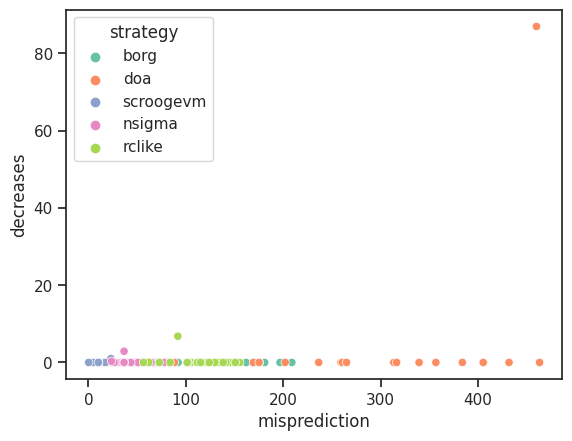

In [79]:
x = sns.scatterplot(without_doa, x='misprediction', y='decreases', hue='strategy')

In [80]:
res_df = compute_eval_metrics(increasing_cumul_res_df, config=256)
res_df.head(n=10)

,strategy,misprediction,violation,decreases
0,borg,15.7,0.0,0.0
1,doa,23.2,22.4,0.3
2,scroogevm,3.7,0.0,0.0
3,maxpeak,15.5,0.0,0.4
4,nsigma,5.7,0.0,0.0
5,percentile,2.1,0.2,0.0
6,rclike,13.3,0.0,0.0


In [86]:
for strategy in increasing_df['strategy'].unique():
    x = increasing_df.loc[increasing_df['strategy'] == strategy]
    print(strategy, round(x['oversubscription'].mean(),2))
    #print(strategy, round(x['oversubscription'].min(),2), round(x['oversubscription'].mean(),2), round(x['oversubscription'].max(),2))

borg 2.26
doa 3.6
scroogevm 2.68
maxpeak 2.27
nsigma 2.61
percentile 2.75
rclike 2.35


# Compare both traces on the same board (Paper figure)

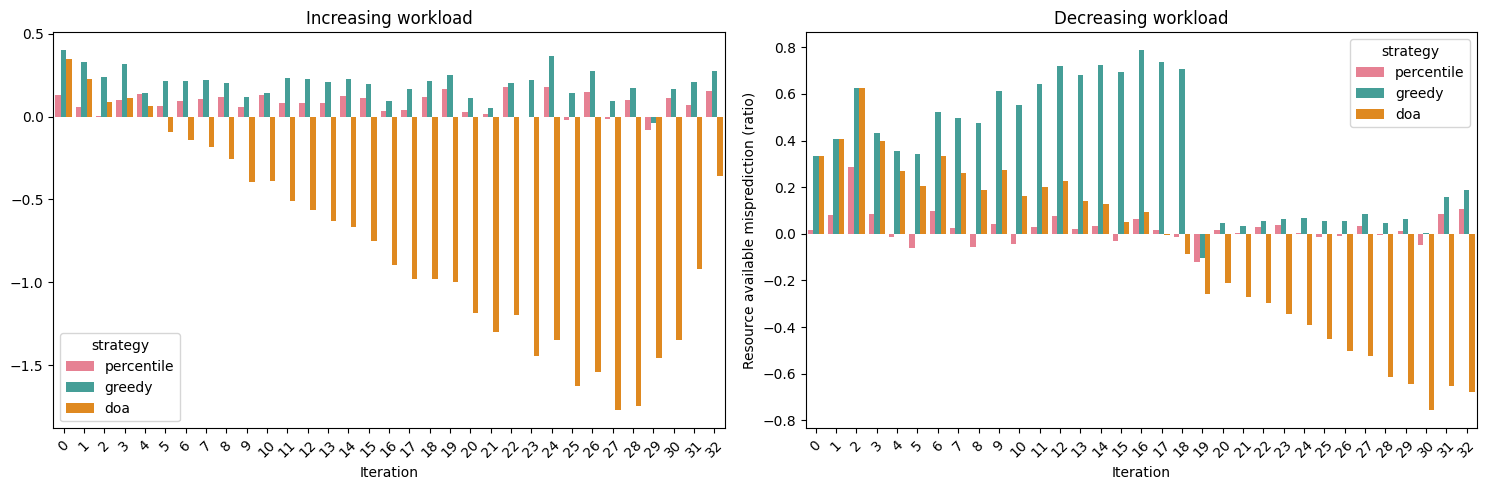

In [46]:
hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))


g = sns.barplot(data=compare_df2, x="iteration", y="current_available_misprediction%", hue="strategy",  palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order, ax=ax1)
ax1.set_title("Increasing workload")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("")
x = ax1.set_xticklabels(ax1.get_xticks(), rotation=45)

g = sns.barplot(data=compare_df, x="iteration", y="current_available_misprediction%", hue="strategy", palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order, ax=ax2)
ax2.set_title("Decreasing workload")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Resource available misprediction (ratio)")
x = ax2.set_xticklabels(ax2.get_xticks(), rotation=45)

fig.tight_layout()